In [ ]:
import os
import glob
from google.colab import drive

In [ ]:
from google.colab import drive
#drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
other_vir_dir = os.path.join("/content/drive/My Drive/CAPSTONE COVID DATASET/581_non_COV/")
main_vir_dir = os.path.join("/content/drive/My Drive/CAPSTONE COVID DATASET/COV_Final/")
main_vir_files = glob.glob(main_vir_dir+'*.png')
other_vir_files = glob.glob(other_vir_dir+'*.png')
#for i in os.walk(main_vir_dir):
  #print(i)

In [ ]:
import numpy as np
import pandas as pd

np.random.seed(42)

files_df = pd.DataFrame({
    'filename': main_vir_files + other_vir_files,
    'label': ['sarscov2'] * len(main_vir_files) + ['other'] * len(other_vir_files)
    }).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head()

,filename,label
0,/content/drive/My Drive/CAPSTONE COVID DATASET...,sarscov2
1,/content/drive/My Drive/CAPSTONE COVID DATASET...,sarscov2
2,/content/drive/My Drive/CAPSTONE COVID DATASET...,sarscov2
3,/content/drive/My Drive/CAPSTONE COVID DATASET...,sarscov2
4,/content/drive/My Drive/CAPSTONE COVID DATASET...,other


In [ ]:
from sklearn.model_selection import train_test_split
from collections import Counter

train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.1, random_state=42)

train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=0.2, random_state=42)

print(train_files.shape, val_files.shape, test_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

(615,) (154,) (86,)
Train: Counter({'sarscov2': 323, 'other': 292}) 
Val: Counter({'sarscov2': 85, 'other': 69}) 
Test: Counter({'sarscov2': 49, 'other': 37})


In [ ]:
train_labels.shape

(615,)

In [ ]:
import cv2
from concurrent import futures
import threading

def get_img_shape_parallel(idx, img, total_imgs):
    if idx % 50 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    return cv2.imread(img).shape
  
ex = futures.ThreadPoolExecutor(max_workers=None)
data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
print('Starting Img shape computation:')
train_img_dims_map = ex.map(get_img_shape_parallel, 
                            [record[0] for record in data_inp],
                            [record[1] for record in data_inp],
                            [record[2] for record in data_inp])
train_img_dims = list(train_img_dims_map)
print('Min Dimensions:', np.min(train_img_dims, axis=0)) 
print('Avg Dimensions:', np.mean(train_img_dims, axis=0))
print('Median Dimensions:', np.median(train_img_dims, axis=0))
print('Max Dimensions:', np.max(train_img_dims, axis=0))

Starting Img shape computation:
ThreadPoolExecutor-2_0: working on img num: 0
ThreadPoolExecutor-2_9: working on img num: 50
ThreadPoolExecutor-2_6: working on img num: 100
ThreadPoolExecutor-2_6: working on img num: 150
ThreadPoolExecutor-2_7: working on img num: 200
ThreadPoolExecutor-2_3: working on img num: 250
ThreadPoolExecutor-2_9: working on img num: 300
ThreadPoolExecutor-2_0: working on img num: 350
ThreadPoolExecutor-2_9: working on img num: 400
ThreadPoolExecutor-2_3: working on img num: 450
ThreadPoolExecutor-2_3: working on img num: 500
ThreadPoolExecutor-2_3: working on img num: 550
ThreadPoolExecutor-2_3: working on img num: 600
ThreadPoolExecutor-2_6: working on img num: 614
Min Dimensions: [1200 1800    3]
Avg Dimensions: [1200. 1800.    3.]
Median Dimensions: [1200. 1800.    3.]
Max Dimensions: [1200 1800    3]


In [ ]:
IMG_DIMS = (64, 64)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 50 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

train_data.shape, test_data.shape, val_data.shape

Loading Train Images:
ThreadPoolExecutor-3_0: working on img num: 0
ThreadPoolExecutor-3_8: working on img num: 50
ThreadPoolExecutor-3_4: working on img num: 100
ThreadPoolExecutor-3_3: working on img num: 150
ThreadPoolExecutor-3_1: working on img num: 200
ThreadPoolExecutor-3_4: working on img num: 250
ThreadPoolExecutor-3_2: working on img num: 300
ThreadPoolExecutor-3_9: working on img num: 350
ThreadPoolExecutor-3_2: working on img num: 400
ThreadPoolExecutor-3_5: working on img num: 450
ThreadPoolExecutor-3_7: working on img num: 500
ThreadPoolExecutor-3_7: working on img num: 550
ThreadPoolExecutor-3_0: working on img num: 600
ThreadPoolExecutor-3_8: working on img num: 614

Loading Test Images:
ThreadPoolExecutor-3_2: working on img num: 0
ThreadPoolExecutor-3_2: working on img num: 50
ThreadPoolExecutor-3_8: working on img num: 85

Loading Validation Images:
ThreadPoolExecutor-3_0: working on img num: 0
ThreadPoolExecutor-3_2: working on img num: 50
ThreadPoolExecutor-3_7: wo

((615, 64, 64, 3), (86, 64, 64, 3), (154, 64, 64, 3))

In [ ]:
BATCH_SIZE = 1
NUM_CLASSES = 2
EPOCHS = 10
INPUT_SHAPE = (64, 64, 3)

train_imgs_scaled = train_data / 255.
test_imgs_scaled = test_data / 255.

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
test_labels_enc = le.transform(test_labels)

print(train_labels[:6], train_labels_enc[:6])

['other' 'other' 'other' 'sarscov2' 'other' 'other'] [0 0 0 1 0 0]


In [ ]:
import tensorflow as tf

In [ ]:
inp = tf.keras.layers.Input(shape=INPUT_SHAPE)

conv1 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(inp)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
#conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(pool1)
#pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(pool1)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

flat = tf.keras.layers.Flatten()(pool3)

hidden1 = tf.keras.layers.Dense(256, activation='relu')(flat)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
#hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
#drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop1)

model = tf.keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 16)        18448     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 4096)              0   

In [ ]:
len(train_labels_enc)

615

In [ ]:
history = model.fit(x=train_imgs_scaled, y=train_labels_enc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(test_imgs_scaled, test_labels_enc),
                    verbose=1)

Epoch 1/10
615/615 [==============================] - 16s 25ms/step - loss: 0.0508 - accuracy: 0.9870 - val_loss: 2.0086e-05 - val_accuracy: 1.0000
Epoch 2/10
615/615 [==============================] - 15s 24ms/step - loss: 1.0695e-04 - accuracy: 1.0000 - val_loss: 3.7297e-05 - val_accuracy: 1.0000
Epoch 3/10
615/615 [==============================] - 15s 24ms/step - loss: 9.4818e-04 - accuracy: 1.0000 - val_loss: 8.1409e-07 - val_accuracy: 1.0000
Epoch 4/10
615/615 [==============================] - 15s 24ms/step - loss: 1.3158e-05 - accuracy: 1.0000 - val_loss: 9.8975e-07 - val_accuracy: 1.0000
Epoch 5/10
615/615 [==============================] - 15s 24ms/step - loss: 0.2913 - accuracy: 0.8049 - val_loss: 0.6888 - val_accuracy: 0.5698
Epoch 6/10
615/615 [==============================] - 14s 23ms/step - loss: 0.6919 - accuracy: 0.5252 - val_loss: 0.6943 - val_accuracy: 0.4302
Epoch 7/10
615/615 [==============================] - 14s 23ms/step - loss: 0.6947 - accuracy: 0.5041 - val_

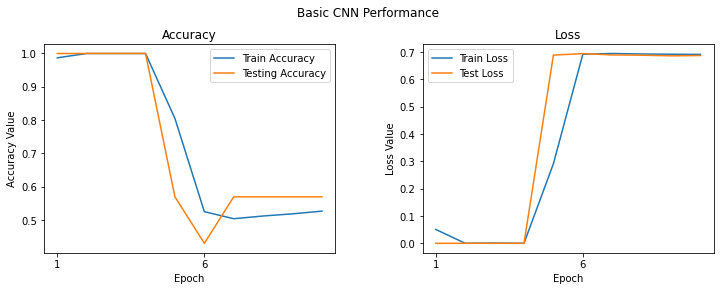

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Testing Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Test Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
val_imgs_scaled = val_data/255.
val_labels_enc = le.transform(val_labels)

# evaluate the model
_, train_acc = model.evaluate(train_imgs_scaled, train_labels_enc, verbose=0)
_, test_acc = model.evaluate(test_imgs_scaled, test_labels_enc, verbose=0)
_, val_acc = model.evaluate(val_imgs_scaled, val_labels_enc, verbose=0)
print('Train: %.3f, Test: %.3f, Val: %.3f' % (train_acc, test_acc, val_acc))

Train: 0.525, Test: 0.570, Val: 0.552


In [ ]:
model.save('covidVSother_fcgr_CNN.h5')